In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, hamming_loss, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from helper_functions import one_hot_encode, standardize_numeric, print_boxed_text
from cluster_comparison import  drop_na_values, perform_umap, perform_hdbscan, calculate_silhouette, plot_clusters
from sklearn.preprocessing import OneHotEncoder, StandardScaler

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/d

In [2]:
# Sample data and demographics DataFrames, replace these with your actual DataFrames
raw_data = pd.read_csv('/Users/leo/Programming/PLR/Leo/data/cleaned_data_SYMPTOMS_9_13_23.csv')
data_symp_groups = pd.read_csv('data/skew_corr_groupadd.csv', usecols=['Grouped_Neuro_Sensory', 'Grouped_Cognitive_Memory', 'Grouped_Gastrointestinal', 'Grouped_Respiratory_Cardiac', 'Grouped_Eye_Vision'])
data_symp_groups_all = pd.read_csv('data/skew_corr_groupadd.csv')
demographics = pd.read_csv('/Users/leo/Programming/PLR/Leo/data/non_binary_data_processed.csv')

In [3]:
# Count the number of NaNs in each column
nan_count_data = data_symp_groups_all.isna().sum()
nan_count_demographics = demographics.isna().sum()

# Print boxed text with NaN information
print_boxed_text(
    [
        "Missing Values Report",
        f"Data DataFrame: {nan_count_data.sum()} NaNs",
        f"Demographics DataFrame: {nan_count_demographics.sum()} NaNs",
    ],
    is_title=[True, False, False],
)

# Find indices of rows with NaNs in 'demographics'
nan_indices = demographics[demographics.isna().any(axis=1)].index

# Report the operation
print_boxed_text([
    "Handling NaNs in the DataFrame",
    "Due to NaNs in the 'demographics' DataFrame, we are also dropping the corresponding rows in the 'data' DataFrame."
], [True, False])

# Drop these indices from both DataFrames
data_symp_groups_all.drop(index=nan_indices, inplace=True)
demographics.drop(index=nan_indices, inplace=True)

# Target and feature dataframes
grouped_symptoms = ['Grouped_Neuro_Sensory', 'Grouped_Cognitive_Memory', 'Grouped_Gastrointestinal', 
                    'Grouped_Respiratory_Cardiac', 'Grouped_Eye_Vision']
y = data_symp_groups_all[grouped_symptoms]
X = demographics

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

┌────────────────────────────────┐
├────────────────────────────────┤
│     Missing Values Report      │
├────────────────────────────────┤
│                                │
│ Data DataFrame: 0 NaNs         │
│ Demographics DataFrame: 0 NaNs │
└────────────────────────────────┘
┌───────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                           Handling NaNs in the DataFrame                                          │
├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                                                   │
│ Due to NaNs in the 'demographics' DataFrame, we are also dropping the corresponding rows in the 'data' DataFrame. │
└───────────

ValueError: Found input variables with inconsistent numbers of samples: [4196, 6031]

┌───────────────────────────────────┐
├───────────────────────────────────┤
│     Model Performance Metrics     │
├───────────────────────────────────┤
│                                   │
│ OOB Score: 0.622566267886465      │
│ Hamming Loss: 0.28105065666041273 │
│ Mean Accuracy: 0.2045028142589118 │
└───────────────────────────────────┘


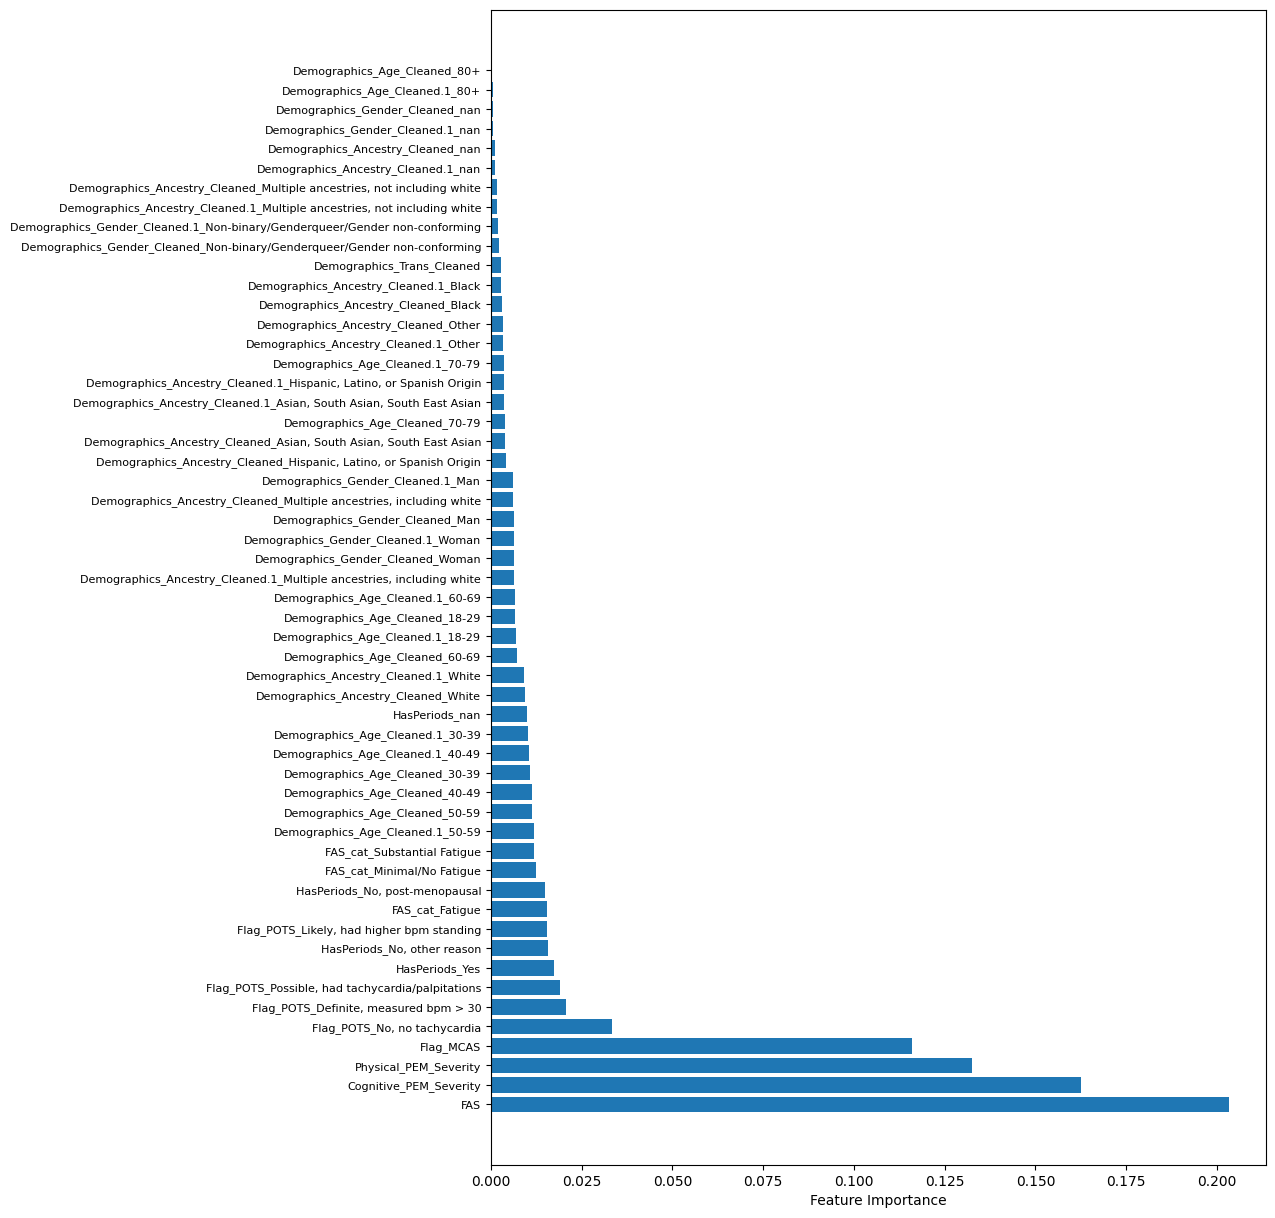

In [ ]:
# Initialize and train the RandomForest model
base_rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
model = MultiOutputClassifier(base_rf, n_jobs=-1)
model.fit(X_train, y_train)

# Mean Accuracy on the test set
mean_accuracy = model.score(X_test, y_test)

# Prediction on the test set
y_pred = model.predict(X_test)

# Hamming Loss
hamming = hamming_loss(y_test, y_pred)

# Use print_boxed_text to show Hamming Loss and Mean Accuracy
print_boxed_text(
    [
        "Model Performance Metrics",
        f"OOB Score: {model.estimators_[0].oob_score_}",
        f"Hamming Loss: {hamming}",
        f"Mean Accuracy: {mean_accuracy}"
    ],
    is_title=[True, False, False, False]
)

# Feature Importances sorted
plt.figure(figsize=(10, 15))  # Make the plot bigger
feature_importances = model.estimators_[0].feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]  # Sort in descending order

plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx], fontsize=8)  # Rotate labels and adjust font size
plt.xlabel('Feature Importance')
plt.show()


In [ ]:
def cluster_comparison(df1, df2):
    df1, df2 = drop_na_values(df1, df2)
    
    df1_umap = perform_umap(df1)
    df2_umap = perform_umap(df2)
    
    labels1 = perform_hdbscan(df1_umap)
    labels2 = perform_hdbscan(df2_umap)
    
    silhouette_df1 = calculate_silhouette(df1_umap, labels1)
    silhouette_df2 = calculate_silhouette(df2_umap, labels2)
    
    print(f"Silhouette score for the first dataframe: {silhouette_df1}")
    print(f"Silhouette score for the second dataframe: {silhouette_df2}")
    
    plt.figure(figsize=(8, 4))
    plt.bar(['First DataFrame', 'Second DataFrame'], [silhouette_df1, silhouette_df2])
    plt.ylabel('Silhouette Score')
    plt.title('Comparison of Silhouette Scores')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plot_clusters(df1_umap, labels1, 'Clusters for First DataFrame')
    
    plt.subplot(1, 2, 2)
    plot_clusters(df2_umap, labels2, 'Clusters for Second DataFrame')
    
    plt.show()

cluster_comparison(data_symp_groups, raw_data)


ValueError: could not convert string to float: 'White'